In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import ndimage
from sklearn.datasets import make_gaussian_quantiles
from sklearn.manifold.t_sne import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import modules.complexity_estimator as ce
import modules.util as u
from modules.oracle import Oracle
from nd_boundary_plot.plots import nd_boundary_plot
from modules import mnist_data

################################################################################################33
#scatter plot of a dataset helper
#
def plot_ds(grid_size, loc, X, y, xx, yy, title, seeds=None, colspan=1, rowspan=1):

    ax = plt.subplot2grid(grid_size, loc, rowspan=rowspan, colspan=colspan)

    ax.set_title(title)
    # Plot also the training points
    ax.scatter(X[:, 0],X[:, 1], c=y)
    # and seeds
    if seeds is not None:
        ax.scatter(X[seeds, 0], X[seeds, 1],
                   alpha=1.0, facecolors='magenta')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

#perform active learning
#
def active(classifiers, datasets, experiments, quota=25, plot_every_n=5):
    # USE THIS INSTEAD OF YTGT WHICH WE PRETEND TO NOT KNOW

    for dsix, ((X_src, y_src), (X_tgt, y_tgt)) in enumerate(datasets):
        u_tgt = [None] * len(X_tgt)
        est_src = ce.ComplexityEstimator(X_src, y_src, n_windows=10, nK=1)
        est_tgt = ce.ComplexityEstimator(X_tgt, y_tgt, n_windows=10, nK=1)
        # declare Dataset instance, X is the feature, y is the label (None if unlabeled)
        X = np.vstack((X_src, X_tgt))
        if X.shape[1] > 2:
            X_src_plt = TSNE().fit_transform(X_src)
            X_tgt_plt = TSNE().fit_transform(X_tgt)
            X_plt = np.vstack((X_src_plt, X_tgt_plt))
        elif X.shape[1] == 2:
            X_src_plt = X_src
            X_tgt_plt = X_tgt
            X_plt = X
        else:
            raise AttributeError

        h = .05  # step size in the mesh
        x_min, x_max = X_plt[:, 0].min() - h, X_plt[:, 0].max() + h
        y_min, y_max = X_plt[:, 1].min() - h, X_plt[:, 1].max() + h
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        figure = plt.figure(figsize=(27, 13))

        grid_size = (1+len(classifiers), 6)
        for n, classifier in enumerate(classifiers):

            model = classifier
            oracle = Oracle(X_tgt, y_tgt)
            # plot src
            plot_ds(grid_size, (0, 0), X_src_plt, y_src, xx, yy, 'Src', est_src.seeds)
            ax = plt.subplot2grid(grid_size, (0,1), colspan=2)
            ax.set_title('Src complexity')
            Ks, Es = est_src.get_k_complexity()
            ax.plot(Ks, Es)
            ax.set_xlabel('AUC=' + ('%.2f' % est_src.auc()).lstrip('0'))

            #plt tgt
            plot_ds(grid_size, (0, 3), X_tgt_plt, y_tgt, xx, yy, 'Tgt', est_tgt.seeds)
            ax = plt.subplot2grid(grid_size, (0,4), colspan=2)
            Ks, Es = est_tgt.get_k_complexity()
            ax.set_title('Tgt complexity')
            ax.plot(Ks, Es)
            ax.set_xlabel('AUC=' + ('%.2f' % est_tgt.auc()).lstrip('0'))
            w = 0
            X_known = X_src.tolist()
            y_known = y_src.tolist()
            for i in range(quota):  # loop through the number of queries
                loc, y_loc = oracle.random_query()  # let the specified QueryStrategy suggest a data to query
                u_tgt[loc] = y_loc
                X_known.append(X_tgt[loc])
                y_known.append(y_tgt[loc])
                if i == 0 or i % plot_every_n == 0 or i == quota - 1:
                    model.fit(X_known, y_known)  # train model with newly-updated Dataset
                    score = model.score(X_tgt, y_tgt)
                    y_predicted = model.predict(X_tgt)
                    ax = plt.subplot2grid(grid_size, (n + 1, w))
                    nd_boundary_plot(X_tgt, y_predicted, model, ax)
                    if i == 0:
                        ax.set_ylabel(u.classname(model))
                    if n == 0:
                        ax.set_title('# queries=' + str(i))
                    ax.set_xlabel('Accuracy='+('%.2f' % score).lstrip('0'))
                    w += 1

        figure.suptitle(experiments[dsix])
        figure.tight_layout()
        fname = './vis/' + str(experiments[dsix]) + '.png'
        figure.savefig(filename=fname)
    plt.tight_layout()
    plt.show()

Completed with X shape:  (100, 784)
Flattened y shape:  (100,)
Completed with X shape:  (100, 784)
Flattened y shape:  (100,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


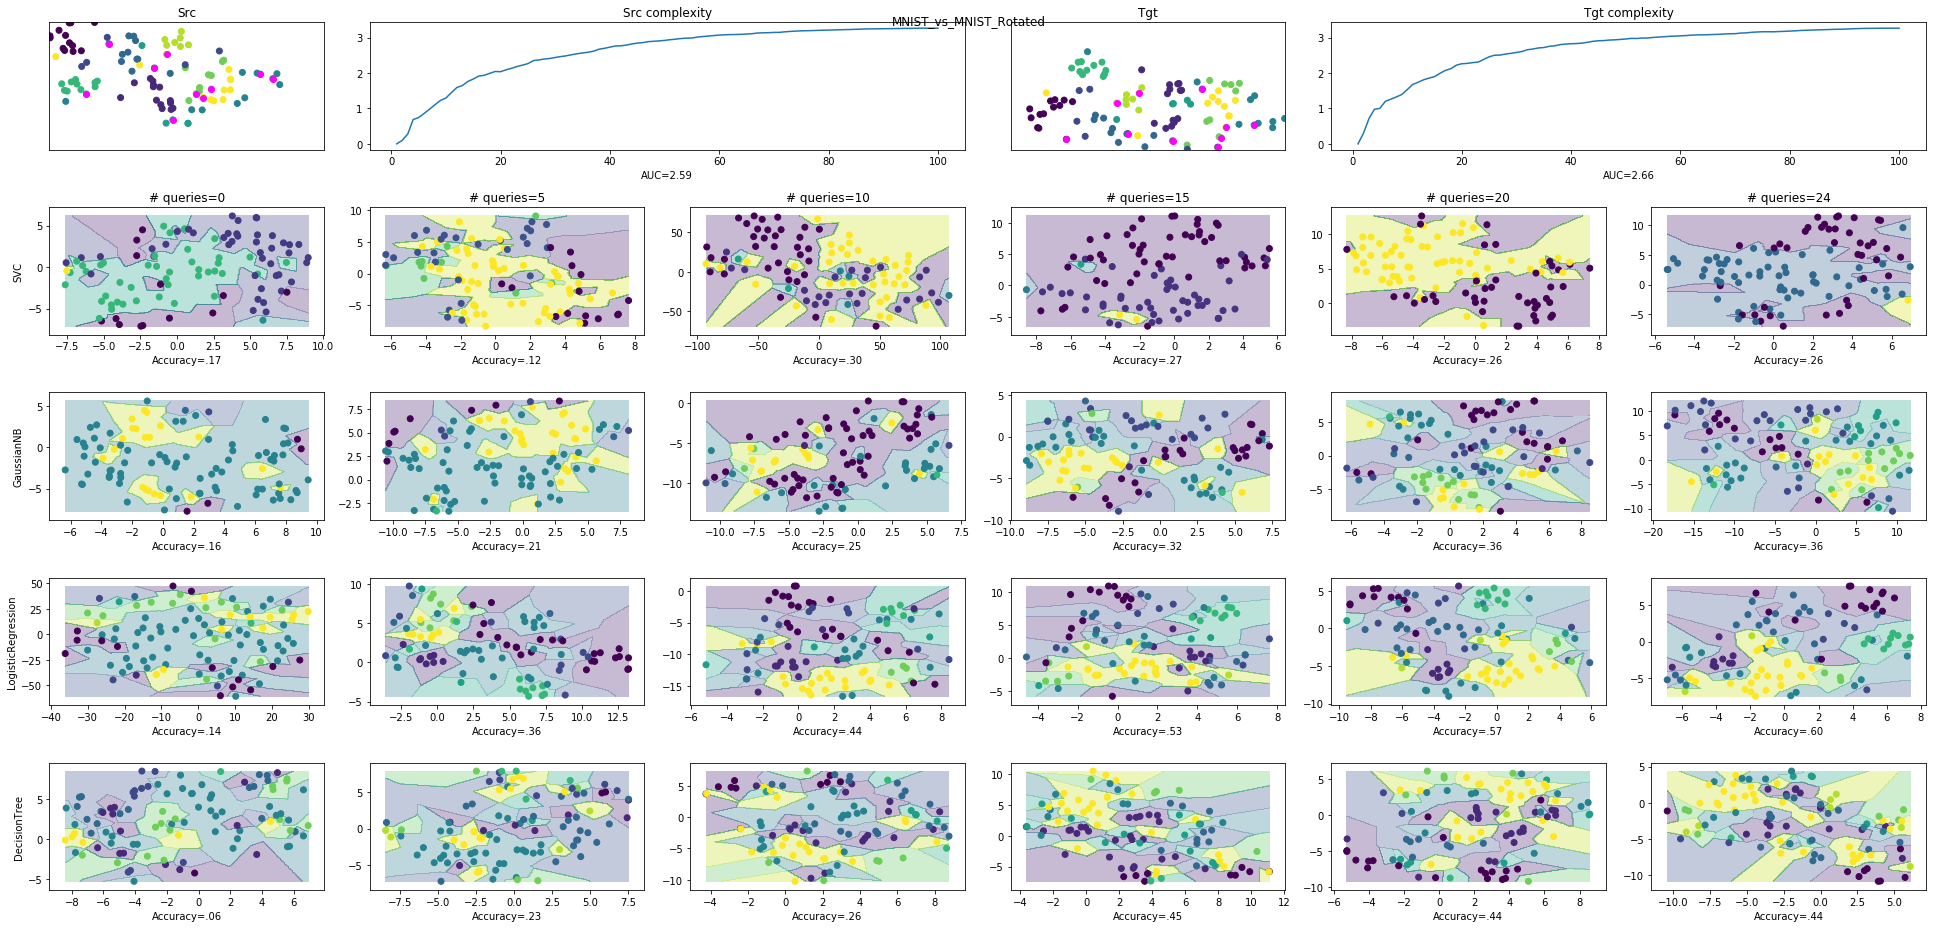

In [2]:
clfs = [SVC(), GaussianNB(), LogisticRegression(solver='sag', max_iter=256), DecisionTreeClassifier()]
datasets = []
experiments = []

datasets.append((mnist_data.load_mnist(), mnist_data.load_mnist_rotated()))
experiments.append('MNIST_vs_MNIST_Rotated')
# datasets.append((u.hastie(500), make_gaussian_quantiles(n_samples=500, n_features=10, n_classes=2)))
# experiments.append('hastie_10_2_vs_gauss_quant_10_2')
# datasets.append((make_moons(), make_circles()))
# experiments.append('moons')
# datasets.append((make_blobs(), make_blobs()))
# experiments.append('blobs')

active(classifiers=clfs, datasets=datasets, experiments=experiments)